In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# (1) Preprocessing: Detect face and eyes

When we look at any image, most of the time we identify a person using a face. An image might contain multiple faces, also the face can be obstructed and not clear. The first step in our pre-processing pipeline is to detect faces from an image. Once face is detected, we will detect eyes, if two eyes are detected then only we keep that image otherwise discard it.
Now how do you detect face and eyes?

In [2]:
img = cv2.imread('C:/Users/Subhrata Sen/Code/ds project 2/test images/Mithali-Raj.jpg')
img.shape

(535, 660, 3)

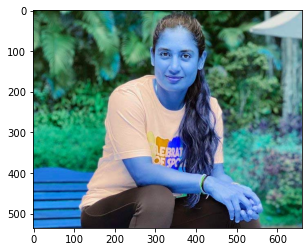

In [3]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(535, 660)

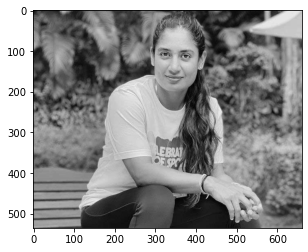

In [5]:
plt.imshow(gray, cmap='gray')

In [6]:
face_cascade = cv2.CascadeClassifier('C:/Users/Subhrata Sen/Code/ds project 2/opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('C:/Users/Subhrata Sen/Code/ds project 2/opencv/haarcascades/haarcascade_eye.xml')
#haarcascade is to detect body features
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[286,  59, 135, 135]])

In [7]:
(x,y,w,h) = faces[0]
x,y,w,h

(286, 59, 135, 135)

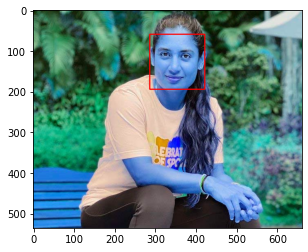

In [8]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)# 255 is for red color
plt.imshow(face_img)

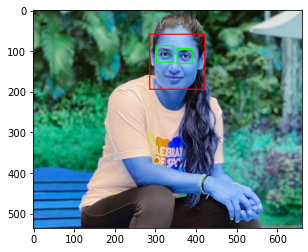

In [9]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)#here 255 is for green color
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

# (2) Preprocessing: Crop the facial region of the image 

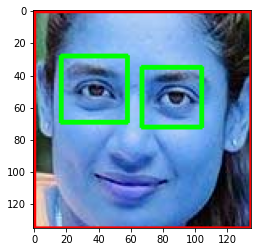

In [10]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')#roi=region of interest

# (3) Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region

Lets write a python function that can take input image and returns cropped image (if face and eyes >=2 are detected)

In [11]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

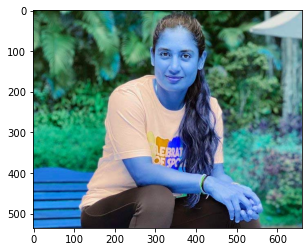

In [12]:
original_image = cv2.imread('C:/Users/Subhrata Sen/Code/ds project 2/test images/Mithali-Raj.jpg')
plt.imshow(original_image)

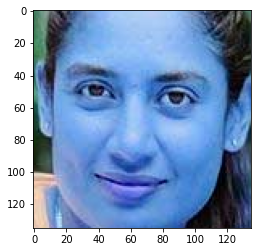

In [13]:
cropped_image = get_cropped_image_if_2_eyes('C:/Users/Subhrata Sen/Code/ds project 2/test images/Mithali-Raj.jpg')
plt.imshow(cropped_image)

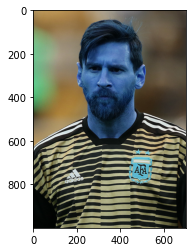

In [14]:
org_image_obstructed = cv2.imread('C:/Users/Subhrata Sen/Code/ds project 2/test images/Lionel_Messi.jpg')
plt.imshow(org_image_obstructed)

In [15]:
path_to_data = "./images/"
path_to_cr_data = "./images/cropped/"

In [16]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
#os.scan goes through all the directories of images folder

In [17]:
img_dirs

['./images/cropped',
 './images/lionel messi',
 './images/mithali raj',
 './images/saina nehwal',
 './images/sania mirza',
 './images/virat kohli']

Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after you run this code

In [18]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [22]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:#iterating through each of the image directories
    count = 1
    celebrity_name = img_dir.split('/')[-1]#giving the last element from the list
    print(celebrity_name)
     
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1 

cropped
lionel messi
Generating cropped images in folder:  ./images/cropped/lionel messi
mithali raj
Generating cropped images in folder:  ./images/cropped/mithali raj
saina nehwal
Generating cropped images in folder:  ./images/cropped/saina nehwal
sania mirza
Generating cropped images in folder:  ./images/cropped/sania mirza
virat kohli
Generating cropped images in folder:  ./images/cropped/virat kohli


Now we have cropped folder under datasets folder that contains cropped images

Finally we are gonna do some manual remediation. Many companies use crowd sourcing platforms to detect the different images other than that of the player.

# (3) Preprocessing: Use wavelet transform as a feature for training our model

**In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc**

We assume that by creating this black and white image we are extracting the important facial features which is going to be very useful to our classifier

In [23]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

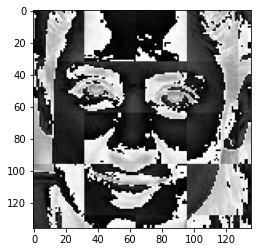

In [24]:
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har, cmap='gray')

**You can see above a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier**

In [25]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'lionel messi': ['./images/cropped/lionel messi\\lionel messi1.png',
  './images/cropped/lionel messi\\lionel messi10.png',
  './images/cropped/lionel messi\\lionel messi11.png',
  './images/cropped/lionel messi\\lionel messi12.png',
  './images/cropped/lionel messi\\lionel messi13.png',
  './images/cropped/lionel messi\\lionel messi14.png',
  './images/cropped/lionel messi\\lionel messi15.png',
  './images/cropped/lionel messi\\lionel messi16.png',
  './images/cropped/lionel messi\\lionel messi17.png',
  './images/cropped/lionel messi\\lionel messi18.png',
  './images/cropped/lionel messi\\lionel messi19.png',
  './images/cropped/lionel messi\\lionel messi2.png',
  './images/cropped/lionel messi\\lionel messi20.png',
  './images/cropped/lionel messi\\lionel messi21.png',
  './images/cropped/lionel messi\\lionel messi22.png',
  './images/cropped/lionel messi\\lionel messi23.png',
  './images/cropped/lionel messi\\lionel messi24.png',
  './images/cropped/lionel messi\\lionel messi25.pn

In [26]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'lionel messi': 0,
 'mithali raj': 1,
 'saina nehwal': 2,
 'sania mirza': 3,
 'virat kohli': 4}

**Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now**

In [27]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [28]:
len(X[0])

4096

In [29]:
32*32*3 + 32*32

4096

In [30]:
X[0]

array([[ 65],
       [ 49],
       [ 56],
       ...,
       [204],
       [234],
       [245]], dtype=uint8)

In [31]:
y[0]

0

In [32]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(350, 4096)

**Data cleaning process is done. Now we are ready to train our model**

We will try SVM as SVM tends to perform good when we are dealing with classification.

We will use SVM with rbf kernel tuned with heuristic finetuning

In [33]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'linear', C = 2))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.875

In [35]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.81      0.76      0.79        17
           2       0.95      0.95      0.95        20
           3       0.83      0.83      0.83        23
           4       0.80      1.00      0.89         8

    accuracy                           0.88        88
   macro avg       0.87      0.89      0.88        88
weighted avg       0.88      0.88      0.87        88



F1 score: In statistical analysis of **binary classification** and information retrieval systems, the F-score or F-measure is a measure of predictive performance. It is calculated from the precision and recall of the test, where the **precision is the number of true positive results divided by the number of all samples predicted to be positive, including those not identified correctly**, and the **recall is the number of true positive results divided by the number of all samples that should have been identified as positive**.Precision is also known as **positive predictive value**, and recall is also known as **sensitivity** in diagnostic binary classification.The **F1 score is the harmonic mean of the precision and recall**.The highest possible value of an F-score is 1.0, indicating perfect precision and recall, and the lowest possible value is 0, if either precision or recall are zero.

**Let's use GridSearch to try out different models with different paramets. Goal is to come up with best model with best fine tuned parameters.**

In [36]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [37]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [38]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.805443,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.545356,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.835776,{'logisticregression__C': 1}


In [39]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [40]:
best_estimators['svm'].score(X_test,y_test)

0.875

In [41]:
best_estimators['random_forest'].score(X_test,y_test)

0.6363636363636364

In [42]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8522727272727273

In [47]:
best_clf = best_estimators['svm']

In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[18,  0,  0,  0,  2],
       [ 0, 13,  0,  4,  0],
       [ 1,  0, 19,  0,  0],
       [ 0,  3,  1, 19,  0],
       [ 0,  0,  0,  0,  8]], dtype=int64)

Text(69.0, 0.5, 'Truth')

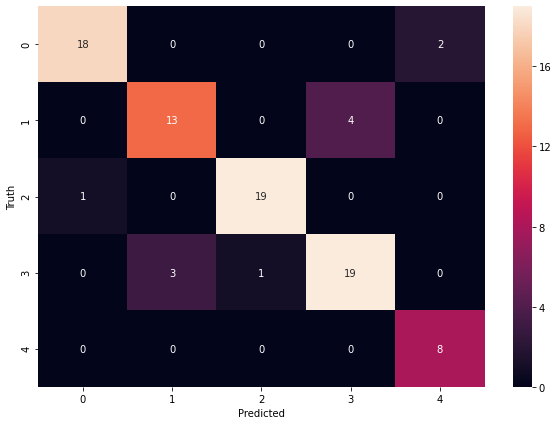

In [49]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [50]:
class_dict

{'lionel messi': 0,
 'mithali raj': 1,
 'saina nehwal': 2,
 'sania mirza': 3,
 'virat kohli': 4}

**Save the trained model**

In [51]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

**Save class dictionary**

In [52]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))